In [1]:
from utils.load_data import load_data
from utils.filters import highpass_filter, lowpass_filter
from plots.plot_signal import plot_signal
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load data
data_abdomen1, data_abdomen2, data_abdomen3, data_thorax1, data_thorax2 = load_data()

# Preprocessing & Signal Processing
1. normalization
2. high pass filter
3. low pass filter
4. 

#### Failed attempts
1. Naive first approach of subtraction - could not successfully isolate.
2. Band-pass filtering - gives signal which looks like sinusoid.
3. Removing combined signal maximums to try and obtain child. Noise was problematic and combined signal wasnt able to be disected.

<Figure size 640x480 with 0 Axes>

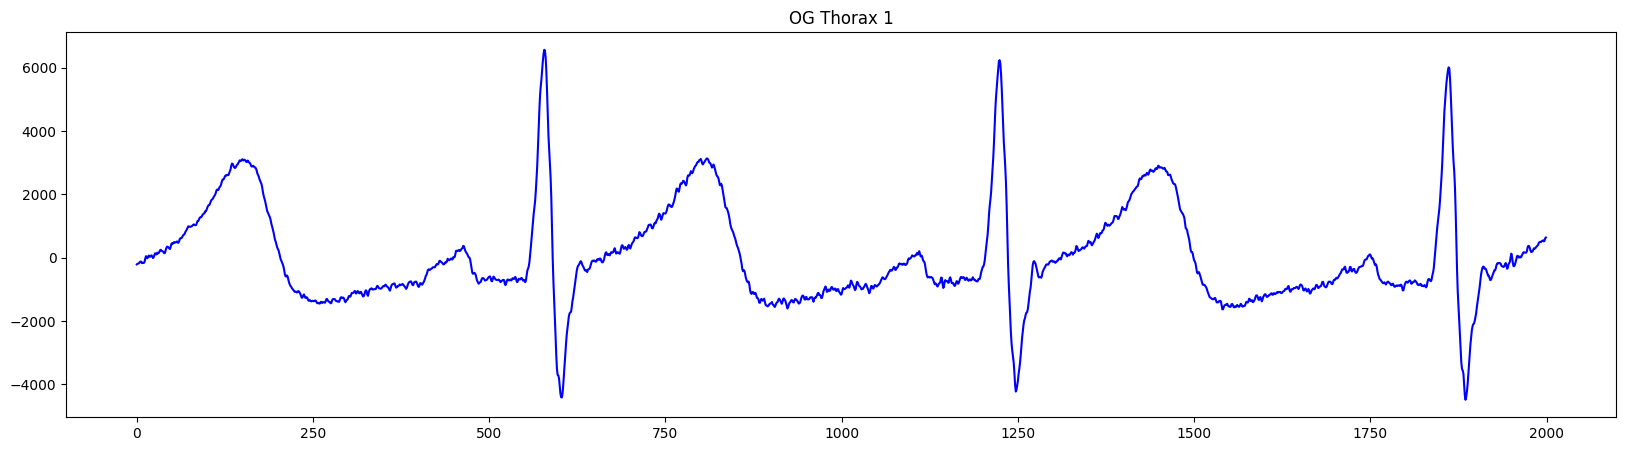

<Figure size 640x480 with 0 Axes>

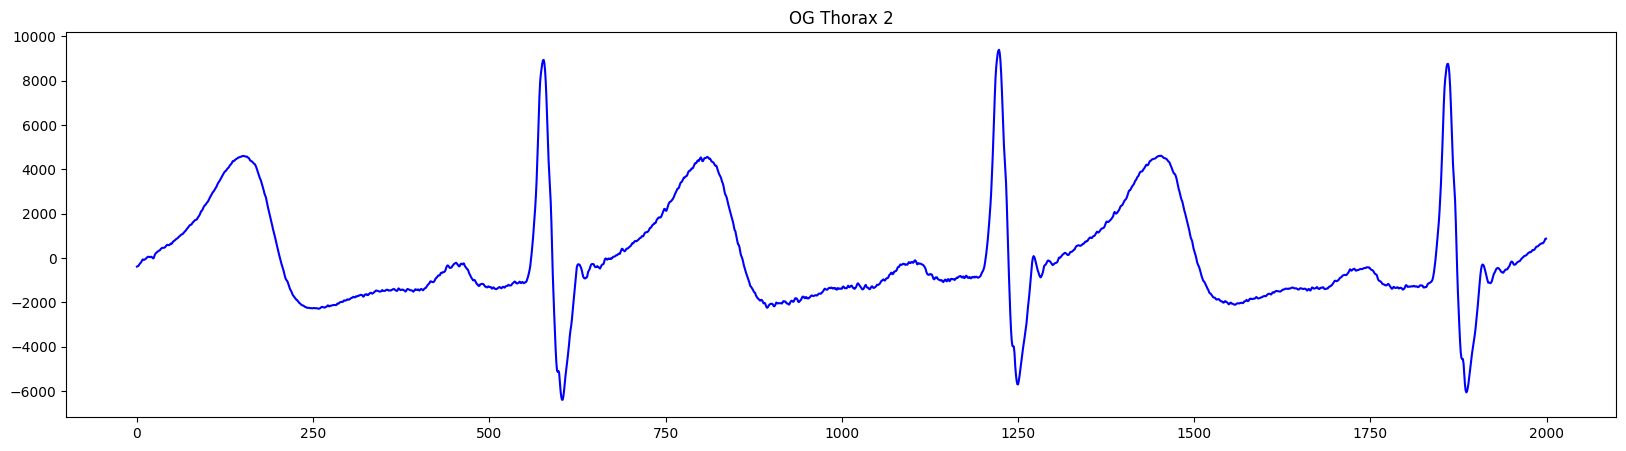

<Figure size 640x480 with 0 Axes>

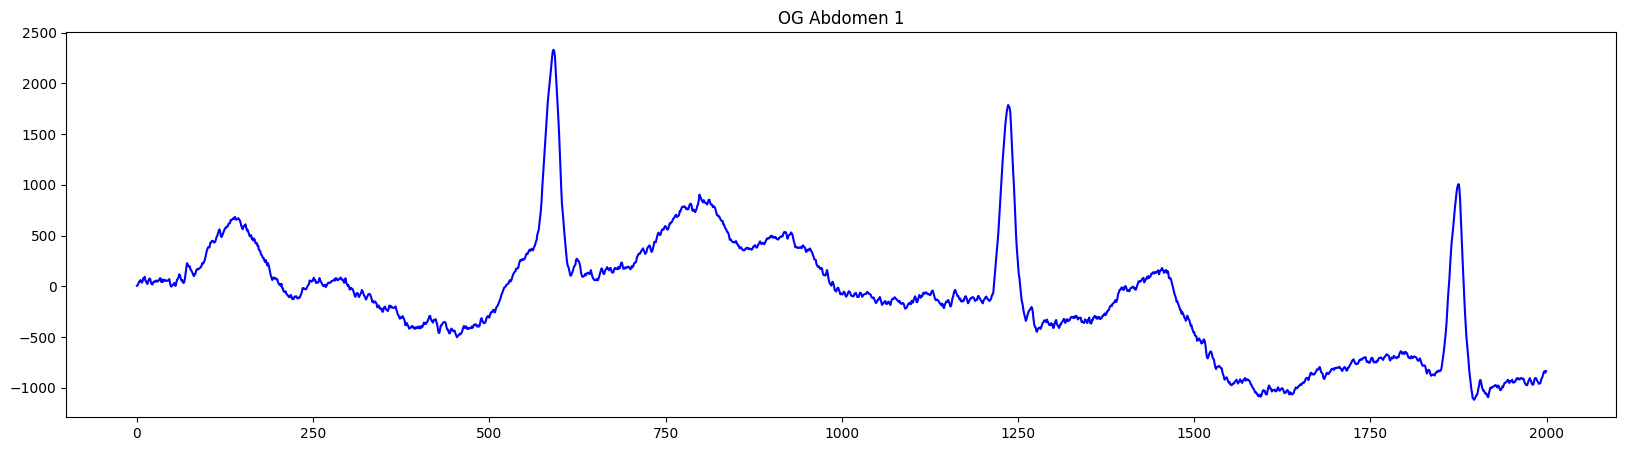

<Figure size 640x480 with 0 Axes>

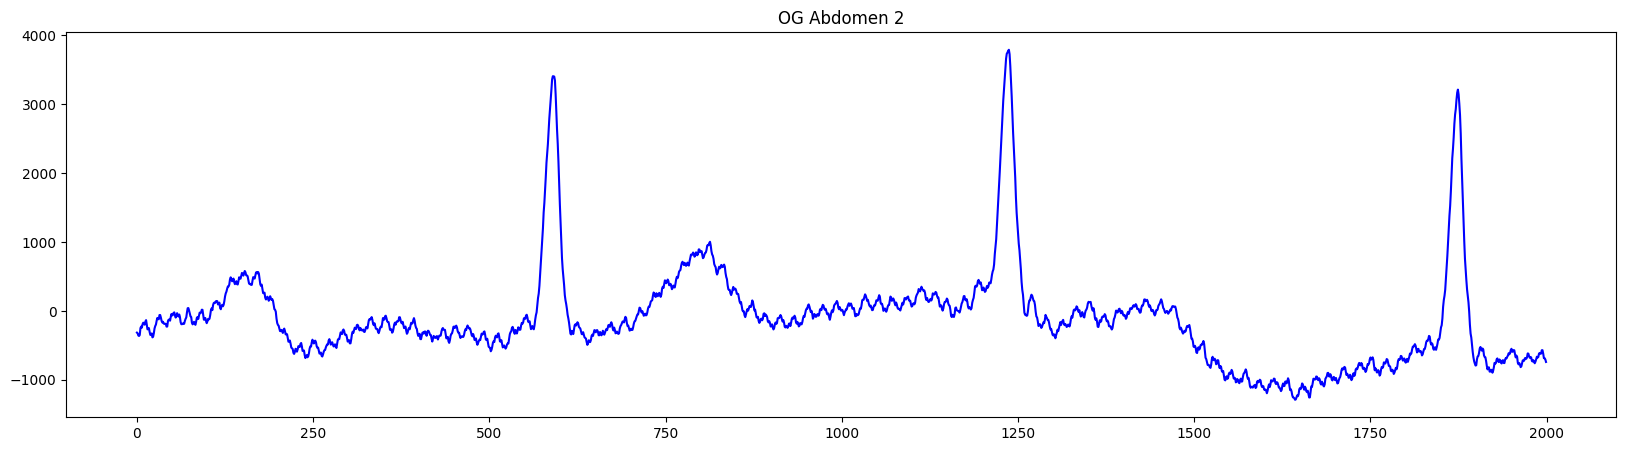

<Figure size 640x480 with 0 Axes>

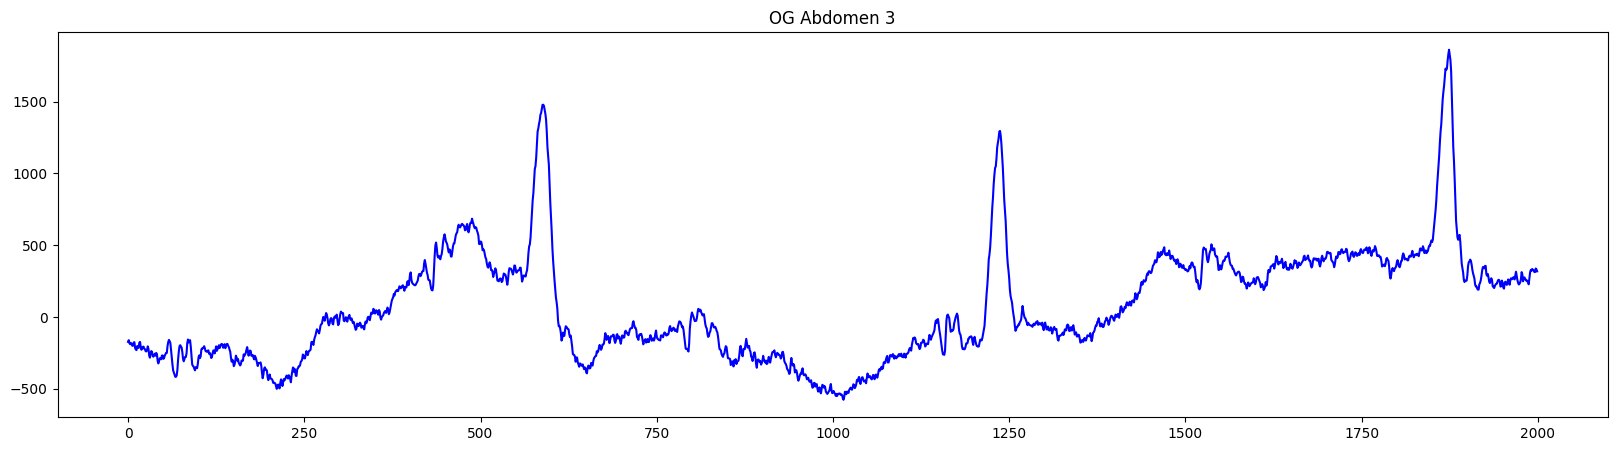

<Figure size 640x480 with 0 Axes>

In [3]:
# Normalize the data to unit variance and zero mean
thorax1 = (data_thorax1 - data_thorax1.mean()) / data_thorax1.std()
thorax2 = (data_thorax2 - data_thorax2.mean()) / data_thorax2.std()
abdomen1 = (data_abdomen1 - data_abdomen1.mean()) / data_abdomen1.std()
abdomen2 = (data_abdomen2 - data_abdomen2.mean()) / data_abdomen2.std()
abdomen3 = (data_abdomen3 - data_abdomen3.mean()) / data_abdomen3.std()

plot_signal(thorax1, "Normalized Thorax 1")
plot_signal(thorax2, "Normalized Thorax 2")
plot_signal(abdomen1, "Normalized Abdomen 1")
plot_signal(abdomen2, "Normalized Abdomen 2")
plot_signal(abdomen3, "Normalized Abdomen 3")


#### High Pass Filter
Why do we use it?

Parameter justification:
  - 
  -
  -

<Figure size 640x480 with 0 Axes>

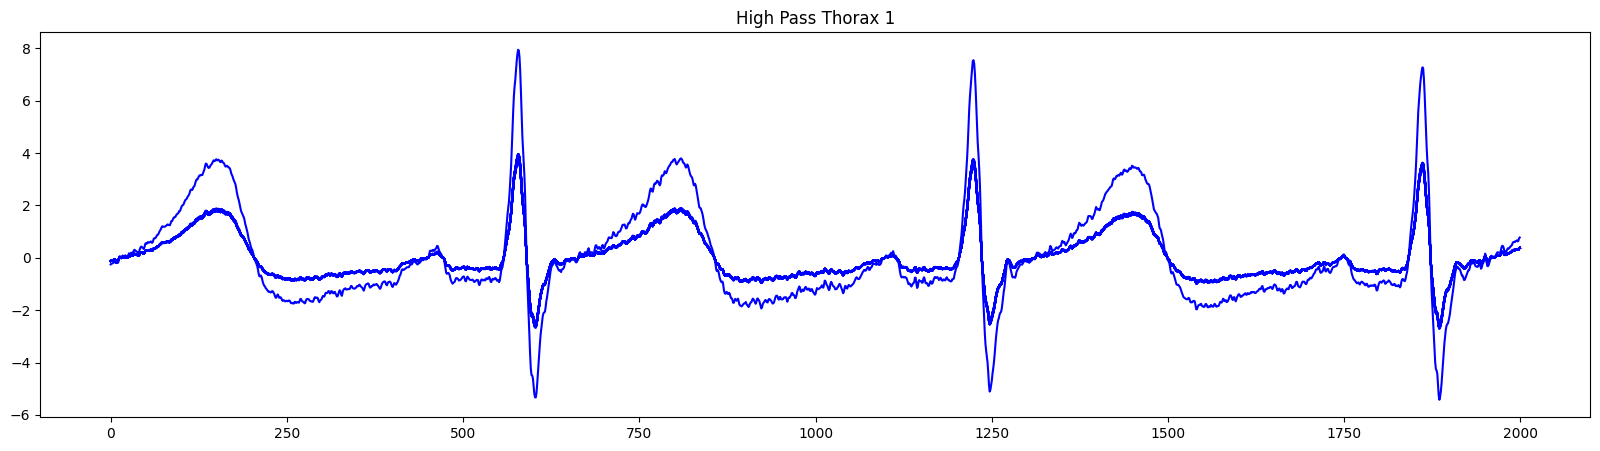

<Figure size 640x480 with 0 Axes>

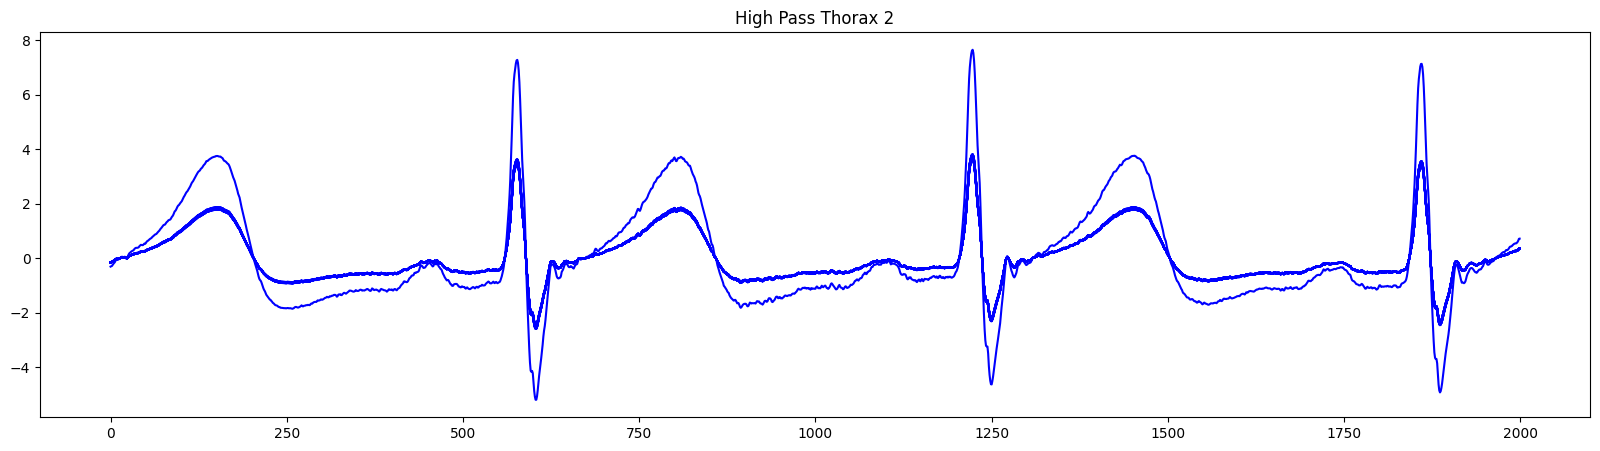

<Figure size 640x480 with 0 Axes>

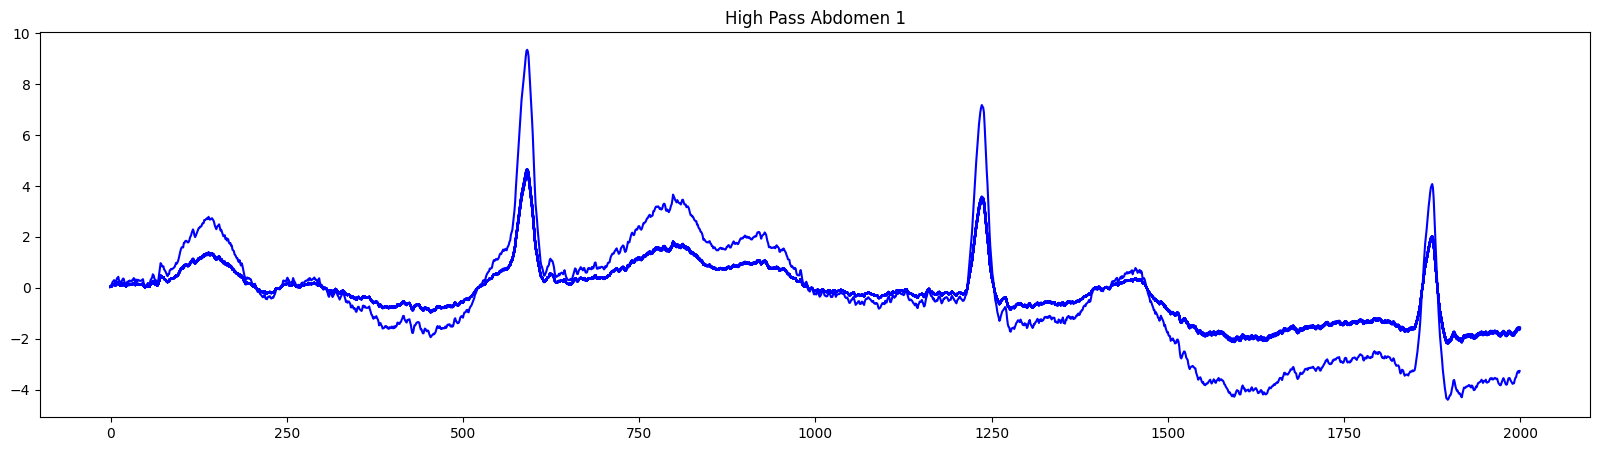

<Figure size 640x480 with 0 Axes>

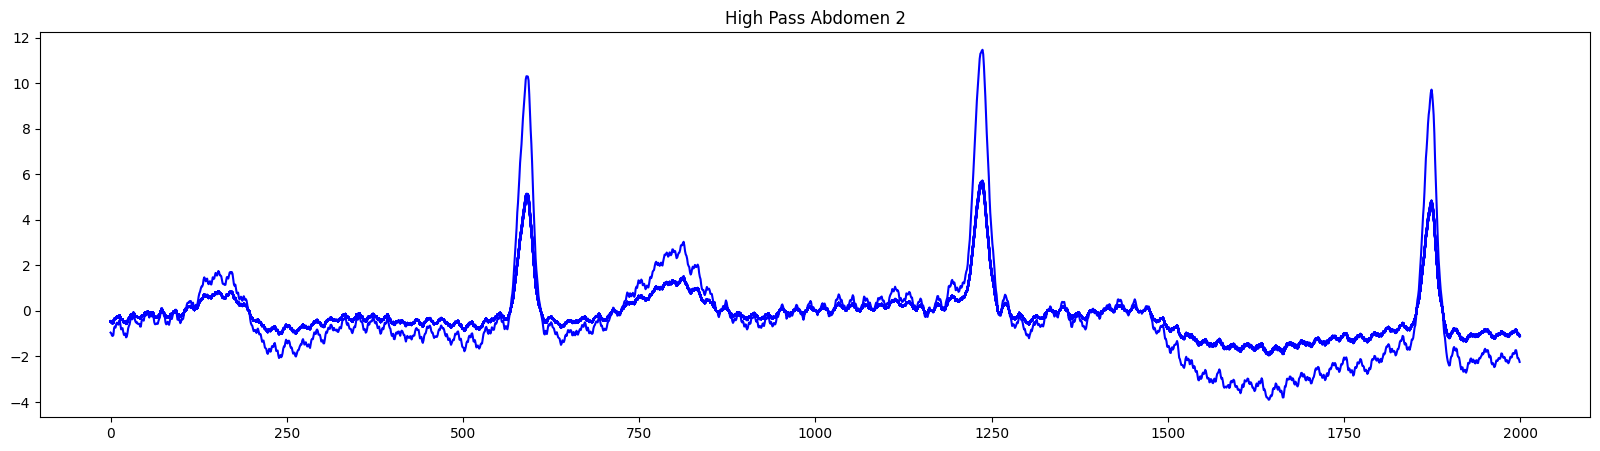

<Figure size 640x480 with 0 Axes>

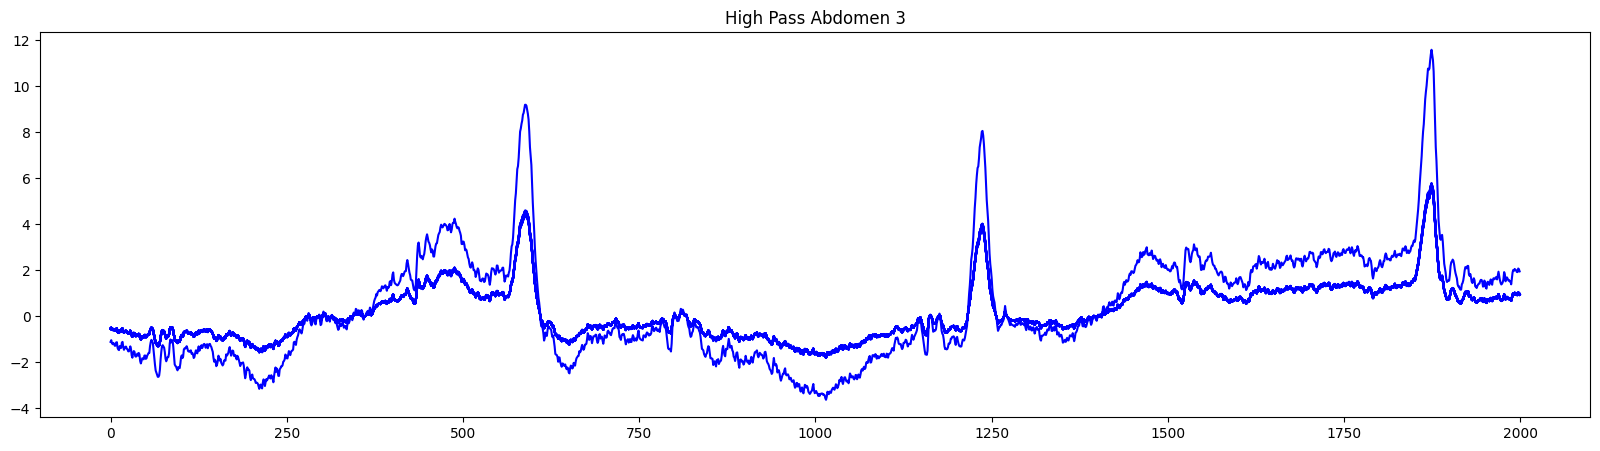

<Figure size 640x480 with 0 Axes>

In [4]:
# High pass filter to remove baseline wander
cutoff_baseline = 0.5
fs = 1000

thorax1 = highpass_filter(thorax1, cutoff_baseline, fs)
thorax2 = highpass_filter(thorax2, cutoff_baseline, fs)
abdomen1 = highpass_filter(abdomen1, cutoff_baseline, fs)
abdomen2 = highpass_filter(abdomen2, cutoff_baseline, fs)
abdomen3 = highpass_filter(abdomen3, cutoff_baseline, fs)

# Plot signal with high pass filter applied
plot_signal(thorax1, "High Pass Thorax 1")
plot_signal(thorax2, "High Pass Thorax 2")
plot_signal(abdomen1, "High Pass Abdomen 1")
plot_signal(abdomen2, "High Pass Abdomen 2")
plot_signal(abdomen3, "High Pass Abdomen 3")

#### Low Pass Filter
Why do we use it?

Parameter Justification:
  - 
  -
  -

<Figure size 640x480 with 0 Axes>

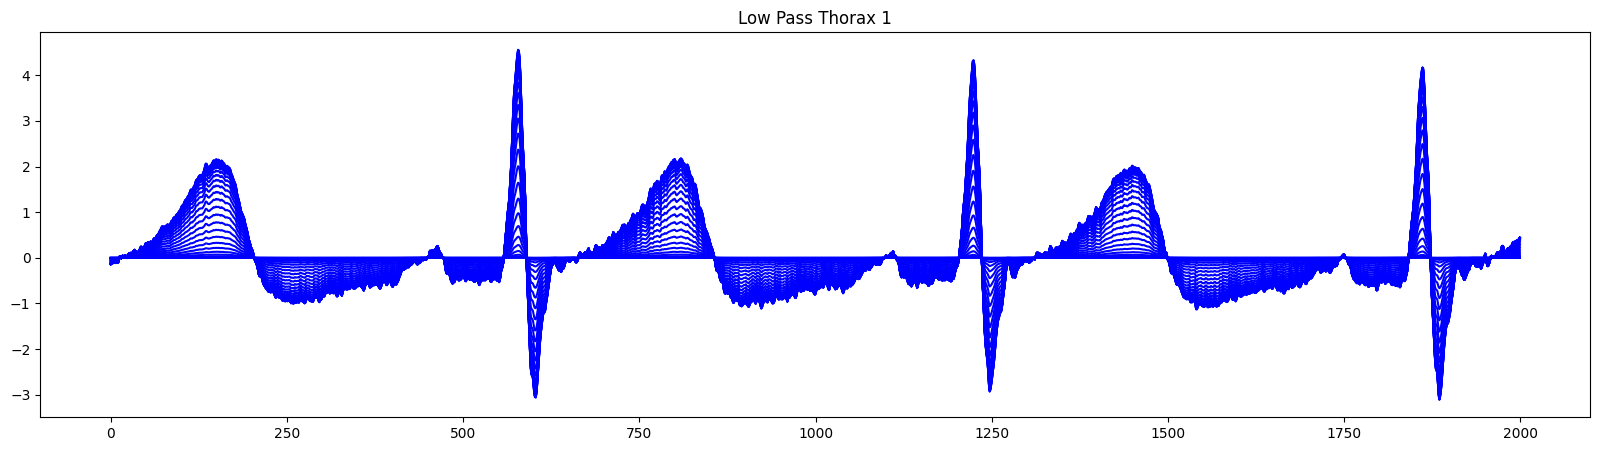

<Figure size 640x480 with 0 Axes>

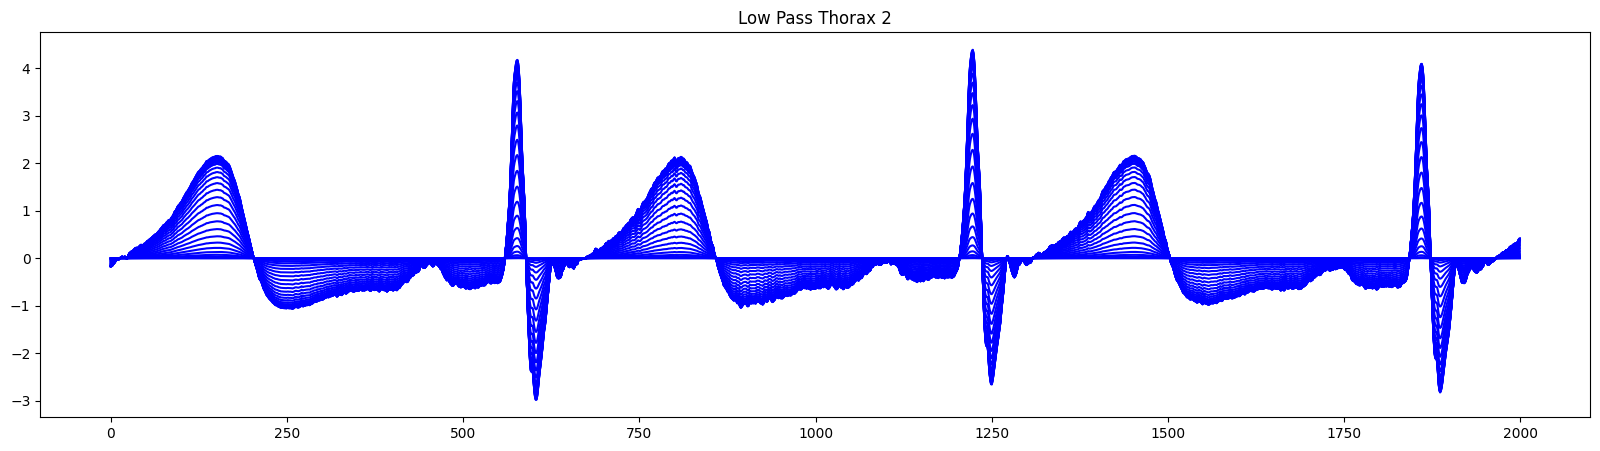

<Figure size 640x480 with 0 Axes>

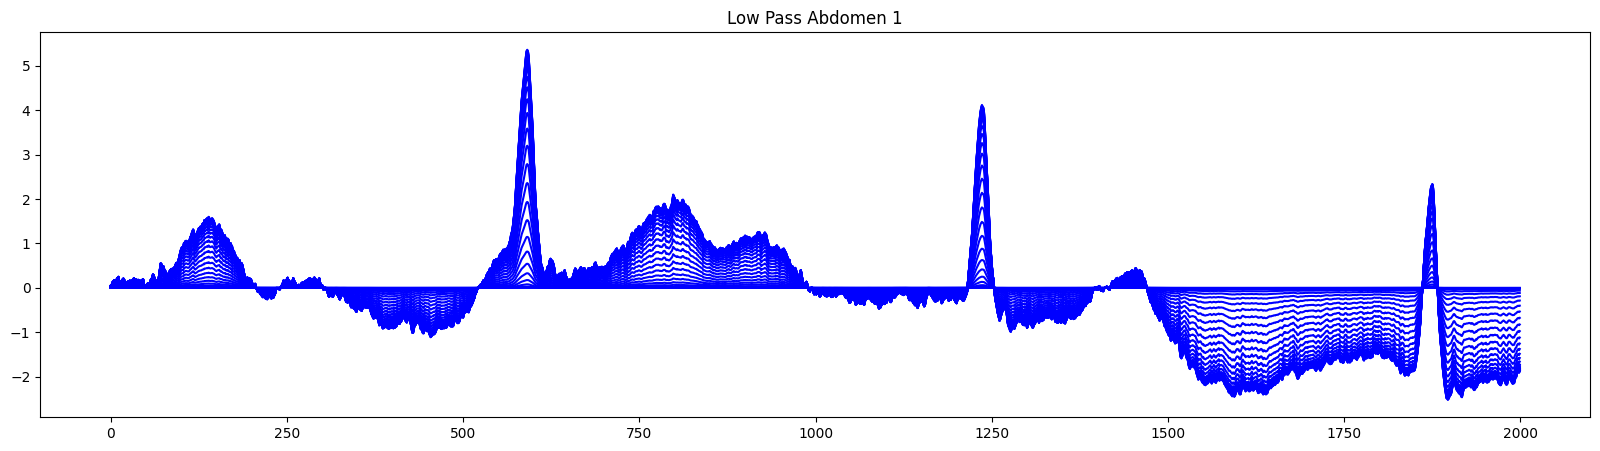

<Figure size 640x480 with 0 Axes>

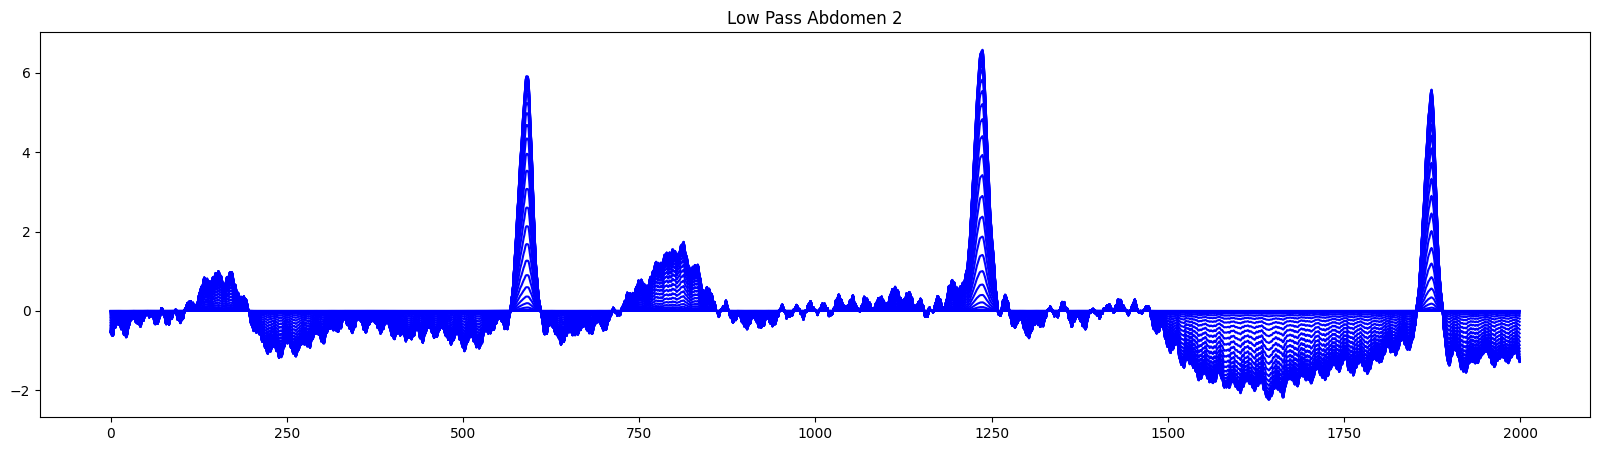

<Figure size 640x480 with 0 Axes>

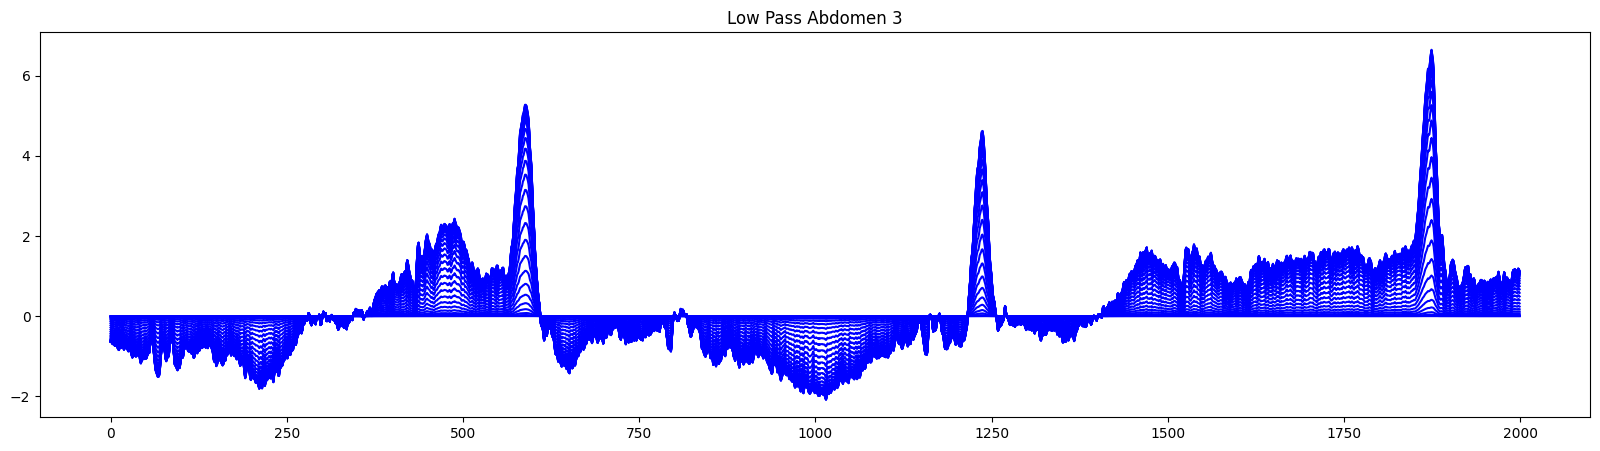

<Figure size 640x480 with 0 Axes>

In [5]:
thorax1 = lowpass_filter(thorax1, 40, fs)
thorax2 = lowpass_filter(thorax2, 40, fs)
abdomen1 = lowpass_filter(abdomen1, 40, fs)
abdomen2 = lowpass_filter(abdomen2, 40, fs)
abdomen3 = lowpass_filter(abdomen3, 40, fs)

# Plot signal with low pass filter applied
plot_signal(thorax1, "Low Pass Thorax 1")
plot_signal(thorax2, "Low Pass Thorax 2")
plot_signal(abdomen1, "Low Pass Abdomen 1")
plot_signal(abdomen2, "Low Pass Abdomen 2")
plot_signal(abdomen3, "Low Pass Abdomen 3")

## Linear Model


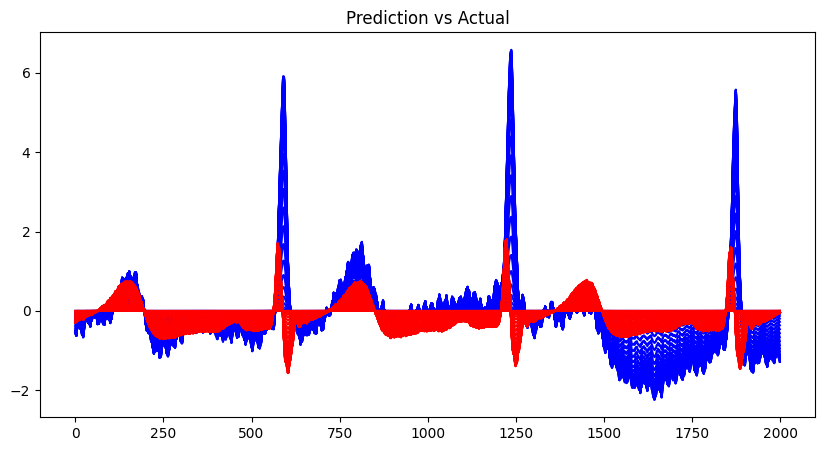

Mean Squared Error on Test Set: 0.6523


In [ ]:
from sklearn.metrics import mean_squared_error
from utils.model import train_linear_model

# print(thorax1)
# print(thorax2)

# Train linear model
linear_model = train_linear_model(thorax1[:2000], abdomen1[:2000])

# Predict using linear model
linear_prediction = linear_model.predict(thorax2[:1200000])

plt.figure(figsize=(10,5))
plt.plot(abdomen2[:2000], label='actual', color='blue')
plt.plot(linear_prediction[:2000], label='prediction', color='red')
plt.title("Prediction vs Actual")
plt.show()

# Measure performance
mse = mean_squared_error(abdomen2[:2000], linear_prediction[:2000])
print(f"Mean Squared Error on Test Set: {mse:.4f}")

# Show abdomen3 - predicted abdominal mECG

plt.figure(figsize=(10,5))
plt.plot(abdomen3[:2000] - linear_prediction[:2000], label='fECG', color='red')
plt.title("Abdomen3 without predicted mECG")
plt.show()